In [5]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)
# df = pd.read_json("../web-crawler/scrapy_mobiliar/mobiscraper/mobiscraper/spiders/scrape_archive/full_scrape_III_with_linkedpages.json")
df = pd.read_json("ratgeber_pages_url.json")
df.shape[0]


148

In [70]:
result = df['linkedpages'].apply(lambda x: len(x) == 0)
filtered_df = df[result]
filtered_df

,url,pagetitle,subtitle,introduction,summarybox,content,accordion,linkedpages
49,https://mym.mobiliar.ch/?language=de,,,,,,,[]
50,https://report.mobiliar.ch/2023/de/,,,,,,,[]
55,https://www.mobiliar.ch/hub/wohnen,,,,,,,[]
86,https://secure.mobiliar.ch/vvn-anliegen/fahrzeugwechsel?language=de,,,,,,,[]
87,https://secure.mobiliar.ch/aro-anliegen/contact?language=de,,,,,,,[]
...,...,...,...,...,...,...,...,...
1698,https://www.mobiliar.ch/hub/wohnen/inspiration,,,,,,,[]
1705,https://www.mobiliar.ch/hub/wohnen/videoartikel,,,,,,,[]
1724,https://www.mobiliar.ch/hub/wohnen/ratgeberartikel,,,,,,,[]
1725,https://www.mobiliar.ch/hub/wohnen/unserhaus/grosses-finale-in-fulenbach,,,,,,,[]


## Matrix build
To build the matrix, we need to list every single linked URL in the X-axis. The individual pages that were scraped are listed in the Y-axis.

In the first step, we need the URL of each scraped page in the form of a list. These can be found in the "url" column.

In the next step, we extract each individual URL from the column of URLs linked on the page, if it is not already in the all_linked_page_urls list, it is added.

In [2]:
all_scraped_page_urls = df.url.tolist()
len(all_scraped_page_urls)

1744

In [3]:
def get_all_page_urls_of_linkedpages_column(pandas_dataframe, column_of_lists_with_linked_pages="linkedpages"):
    all_linked_page_urls = []
    for i in pandas_dataframe.index:
        list_of_linked_pages_per_url = pandas_dataframe.loc[i, column_of_lists_with_linked_pages]
        for linkedpage in list_of_linked_pages_per_url:
            if linkedpage not in all_linked_page_urls:
                all_linked_page_urls.append(linkedpage)
    return all_linked_page_urls

all_linked_page_urls = get_all_page_urls_of_linkedpages_column(df)
len(all_linked_page_urls)

3668

In [4]:
# liste_der_verbindungen = []
# for i in df.index:
#     list_of_linked_pages_per_url = df.loc[i, "linkedpages"]
#     li = [df.loc[i, "url"]] * len(list_of_linked_pages_per_url)
#     data = list(zip(li, list_of_linked_pages_per_url))
#     liste_der_verbindungen += data
# len(liste_der_verbindungen)

## Fill Matrix

Next, we want to fill the matrix. If the respective page (row) in your content links to the other website as an X-axis attribute, enter True, otherwise False. 

In [38]:
# To figure out how to make it work, I've used this simple Test
liste_mit_allen_linked_urls = ["A", "B", "C", "D", "E", "F", "G", "H"]
A = ["A", "H", "D"]
B = ["D", "F"]
C = ["D"]
D = ["G", "H"]
E = ["E", "F", "H"]
F = ["C", "E"]
G = ["A", "F", "H"]
H = ["B", "G"]

liste_aller_page_urls = []
for i in range(len([A,B,C,D,F,G,H])):
    for e in [A,B,C,D,F,G,H][i]:
        if e not in liste_aller_page_urls:
            liste_aller_page_urls.append(e)
liste_aller_page_urls

test_matrix = pd.DataFrame(columns=liste_mit_allen_linked_urls)

for page_url in liste_aller_page_urls:
    ist_in_liste_mit_allen_linked_urls = [(buchstabe in page_url) for buchstabe in liste_mit_allen_linked_urls]
    new_row = dict(zip(test_matrix.columns, ist_in_liste_mit_allen_linked_urls))      
    test_matrix = pd.concat([test_matrix, pd.DataFrame([new_row])], ignore_index=True)
test_matrix = test_matrix.assign(page_url=["A", "B", "C", "D", "E", "F", "G", "H"])
test_matrix

# And a data frame with characteristics for your nodes
carac = pd.DataFrame({ 'page_url':['A', 'B', 'C', 'D'], 'color':[(0,1,0),(1,0,0),(1,0,0),(0,1,0),(0,1,0),(0,0,1),(0,1,0),(0,0,0),(0,0,1)]})

,A,B,C,D,E,F,G,H,page_url
0,True,False,False,False,False,False,False,False,A
1,False,False,False,False,False,False,False,True,B
2,False,False,False,True,False,False,False,False,C
3,False,False,False,False,False,True,False,False,D
4,False,False,False,False,False,False,True,False,E
5,False,False,True,False,False,False,False,False,F
6,False,False,False,False,True,False,False,False,G
7,False,True,False,False,False,False,False,False,H


In [34]:
def get_connection_matrix(pandas_dataframe, column_containing_list_of_all_linked_pages_per_url):

    # column_names = get_all_page_urls_of_linkedpages_column(pandas_dataframe)
    column_names = pandas_dataframe.url.tolist()

    if column_names[0] != "url":
        column_names.insert(0, "url")

    assert column_names[0] == "url", "first Element must be 'url'."
    assert column_names[1].startswith("https://"), "second Element must start with 'https://...'." 

    matrix = pd.DataFrame(columns=column_names)
    list_with_no_linked_pages = []
    all_scraped_page_urls = pandas_dataframe.url.tolist()

    for url in all_scraped_page_urls:
        idx = all_scraped_page_urls.index(url)
        list_of_linked_pages_per_url = pandas_dataframe.loc[pandas_dataframe.index[pandas_dataframe["url"]==url].tolist(), column_containing_list_of_all_linked_pages_per_url]
        is_in_list_of_all_linked_urls = [(linked_page in list_of_linked_pages_per_url[idx]) for linked_page in column_names]
        is_in_list_of_all_linked_urls[0] = url
        new_row = dict(zip(matrix.columns, is_in_list_of_all_linked_urls))      
        matrix = pd.concat([matrix, pd.DataFrame([new_row])], ignore_index=True)

    return matrix

In [ ]:
matrix = get_connection_matrix(pandas_dataframe=df, column_containing_list_of_all_linked_pages_per_url="linkedpages")
matrix

In [8]:

matrix.iloc[0].value_counts()

0
False                                                                               95
True                                                                                53
https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/ratgeber     1
Name: count, dtype: int64

In [74]:
# Number of rows that all have false values
matrix.loc[(matrix.iloc[:, 1:] == False).all(axis=1)]
# Number of columns that all have false values
len(matrix.columns[(matrix == False).all()])

,page_url,https://www.mobiliar.ch,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/tierversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/cyberversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/mietkautionsversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/wertsachenversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/gebaeudeversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/privathaftpflichtversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/privat-rechtsschutz,...,https://www.mobiliar.ch/die-mobiliar/ueber-uns/innovation-bei-der-mobiliar,https://www.mobiliar.ch/die-mobiliar/ueber-uns/geschaeftsbericht/download-center/geschaeftsbericht-bestellen,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet/die-mobiliar-praesentiert-das-leben,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet/189-millionen-erfolgsbeteiligung-dank-genossenschaft,https://www.mobiliar.ch/die-mobiliar/ueber-uns/innovation-bei-der-mobiliar/wir-befaehigen-fuer-die-zukunft,https://www.mobiliar.ch/die-mobiliar/ueber-uns/innovation-bei-der-mobiliar/wir-denken-zukunft,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet/leitbild-der-gruppe-mobiliar,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unsere-werbung/werbespots-liebe-mobiliar/geisterhaus-spot-gewinnt-silber-edi,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unsere-werbung/werbespots-liebe-mobiliar/25-jahre-liebe-mobiliar
49,https://mym.mobiliar.ch/?language=de,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
50,https://report.mobiliar.ch/2023/de/,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
55,https://www.mobiliar.ch/hub/wohnen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
86,https://secure.mobiliar.ch/vvn-anliegen/fahrzeugwechsel?language=de,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
87,https://secure.mobiliar.ch/aro-anliegen/contact?language=de,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,https://www.mobiliar.ch/hub/wohnen/inspiration,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1705,https://www.mobiliar.ch/hub/wohnen/videoartikel,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1724,https://www.mobiliar.ch/hub/wohnen/ratgeberartikel,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1725,https://www.mobiliar.ch/hub/wohnen/unserhaus/grosses-finale-in-fulenbach,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [91]:
A = ["D", "H"]
B = ["A", "C"]
C = ["A", "B", "C", "D"]
D = ["B", "C", "H"]

data = {
    "url": ["A", "B", "C", "D"],
    "linkedpages": [A, B, C, D,]
}
df = pd.DataFrame(data)

all_scraped_page_urls = df.url.tolist()
column_names = df.url.tolist()
column_names.insert(0, "url")

matrix = pd.DataFrame(columns=column_names)

for page_url in all_scraped_page_urls:
    idx = all_scraped_page_urls.index(page_url)
    list_of_linked_pages_per_url = df.loc[df.index[df["url"]==page_url].tolist(), "linkedpages"]
    is_in_list_of_all_linked_urls = [(linked_page in list_of_linked_pages_per_url[idx]) for linked_page in column_names]
    is_in_list_of_all_linked_urls[0] = page_url
    new_row = dict(zip(matrix.columns, is_in_list_of_all_linked_urls))      
    matrix = pd.concat([matrix, pd.DataFrame([new_row])], ignore_index=True)

# carac = pd.DataFrame({ 'page_url':['A', 'B', 'C', 'D'], 'color':[(0,0.5,0),(0.86,0,0),(1,1,0),(0.8,0.25,0)]})
matrix

,url,A,B,C,D
0,A,False,False,False,True
1,B,True,False,True,False
2,C,True,True,True,True
3,D,False,True,True,False


In [92]:
data = {
    "url": ["A", "B", "C", "D"],
    "negative": [0.4, 0.8, 0.0, 0.1],
    "neutral": [0.2, 0.2, 0.1, 0.8],
    "positive": [0.4, 0.0, 0.9, 0.1],
}
sentiment_data = pd.DataFrame(data)
sentiment_data

,url,negative,neutral,positive
0,A,0.4,0.2,0.4
1,B,0.8,0.2,0.0
2,C,0.0,0.1,0.9
3,D,0.1,0.8,0.1


In [89]:
def get_color(input_vector):
    import numpy as np
    
    red = np.array([1, 0, 0])
    yellow = np.array([1, 1, 0])
    green = np.array([0, 1, 0])

    rgb = input_vector[0] * red + input_vector[1] * yellow + input_vector[2] * green

    color = '#' + ''.join(f'{int(x*255):02x}' for x in rgb)
    return color

def add_color_column_of_df_to_matrix(matrix, dataframe):
    dataframe["color"] = dataframe[['negative', 'neutral', 'positive']].apply(lambda row: np.array(row), axis=1).apply(lambda row: get_color(row))
    result = pd.merge(matrix, dataframe[["url", "color"]], how="left", on=["url"])
    return result

In [94]:
test_matrix = add_color_column_of_df_to_matrix(matrix, sentiment_data)
test_matrix

,url,A,B,C,D,color
0,A,False,False,False,True,#999900
1,B,True,False,True,False,#ff3300
2,C,True,True,True,True,#19ff00
3,D,False,True,True,False,#e5e500


In [79]:
matrix = get_connection_matrix(pandas_dataframe=pd.read_json("beispiel.json"), column_containing_list_of_all_linked_pages_per_url="linkedpages")
sa_data = pd.read_json("../sentiment-analyser/distilbert_s_a_result_14-04-24.json")
sa_data_with_color = add_color_column_of_df_to_matrix(matrix, sa_data)

In [84]:
fw_matrix = get_connection_matrix(pandas_dataframe=pd.read_json("../web-crawler/scrapy_mobiliar/mobiscraper/mobiscraper/spiders/scrape_archive/full_scrape_III_with_linkedpages.json"), column_containing_list_of_all_linked_pages_per_url="linkedpages")
full_website = add_color_column_of_df_to_matrix(fw_matrix, sa_data)

# Graph

In [12]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network


In [85]:
def get_graph_from_matrix(matrix_df):
    import networkx as nx
    from pyvis.network import Network

    G = nx.DiGraph()
    for idx, row in matrix_df.iterrows():
        G.add_node(row['url'], color=row['color'], size=80)
        start_node = row["url"]
        for column in matrix_df.columns:
            if matrix_df.loc[idx,column] == True:
                end_node = column
                G.add_edge(start_node, end_node, color="#018786")

    # isolates = list(nx.isolates(G))
    # G.remove_nodes_from(isolates)
    # for i in isolates:
    #     print(i)

    # Change size
    # d = dict(G.degree)
    # d.update((x, 1.3*y) for x, y in d.items())
    # nx.set_node_attributes(G, d, "size")

    N = Network(height='1500px', width='100%', bgcolor="#222222", font_color="white", directed=True, notebook=False)
    N.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, spring_strength=0.001, damping=0.09, overlap=0) # force_atrlas_2based() hrepulsion()
    N.from_nx(G)
    N.show_buttons()

    # N.set_options("""
    # var options = {
    # "physics": {
    #     "enabled": false
    # }
    # }
    # """)

    # neighbor_map = N.get_adj_list()
    # print(neighbor_map)
    for node in N.nodes:
        node_id = node["id"]
        node["color"] = G.nodes[node_id]["color"]
    #     node["title"] = "    Neighbors:<br>" + "<br>".join(neighbor_map[node[""]])

    return G, N

In [83]:
G_1, N_1 = get_graph_from_matrix(sa_data_with_color)
N.show("ex.html")

In [130]:
G, N = get_graph_from_matrix(full_website)
N.show("full_website.html")

# Graph analysis

In [128]:
G_example, N_example = get_graph_from_matrix(test_matrix)

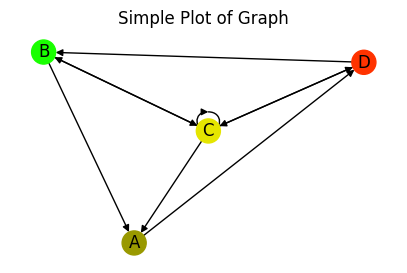

In [119]:
plt.figure(figsize=(5, 3))
# nx.draw(G_test, with_labels=True, node_color='skyblue', node_size=500, font_size=8)
plt.title('Simple Plot of Graph')
# plt.show()

nx.draw(G, with_labels=True, node_color=test_matrix['color'])
plt.show()

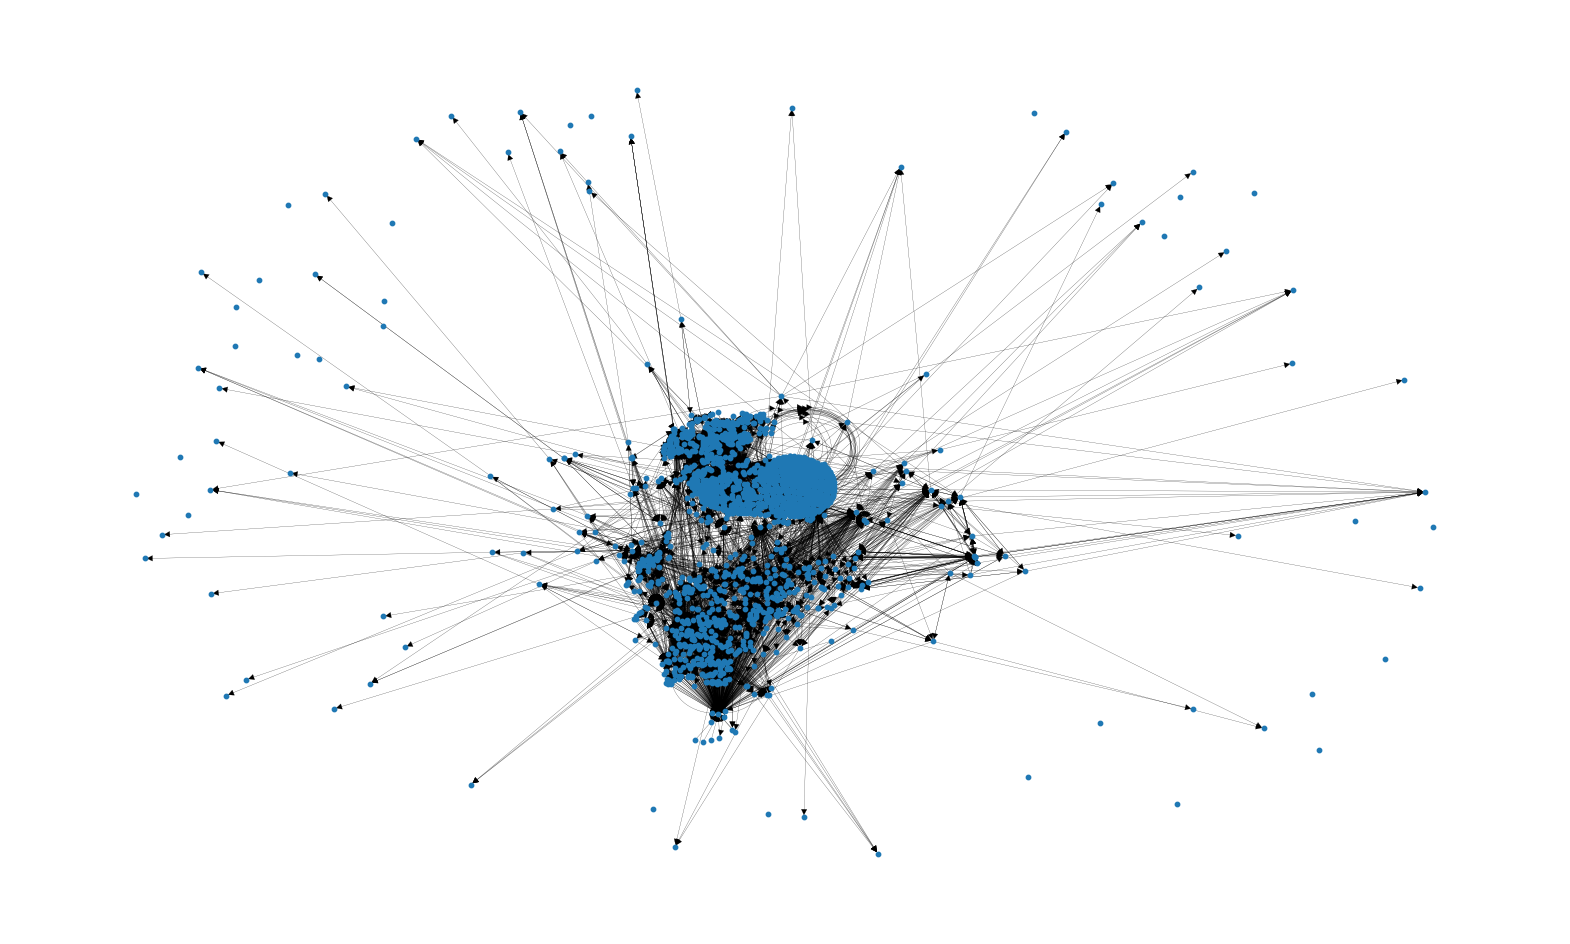

In [135]:
pos = nx.spring_layout(G, iterations=20, seed=1721)
fig, ax = plt.subplots(figsize=(20, 12))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

## Graph properties

In [143]:
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [144]:
nodes, edges = G.order(), G.size()
print("SCC: ", nx.number_strongly_connected_components(G))
print("WCC: ", nx.number_weakly_connected_components(G))

SCC:  94
WCC:  1


In [145]:
# https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#basic-topological-attributes

print("number of nodes:", G.number_of_nodes())
print("number of edges:", G.number_of_edges())
print("average connected nodes per node:", np.mean([d for _, d in G.degree()]))

# Compute the average shortest path length for each node
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

number of nodes: 1716
number of edges: 9652
average connected nodes per node: 11.249417249417249


6.113301865696317

In [152]:

diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

NetworkXError: Found infinite path length because the digraph is not strongly connected

# Degree distribution

In [117]:
G.out_degree()



OutDegreeView({'A': 1, 'D': 2, 'B': 2, 'C': 4})

Text(0.5, 1.0, 'network of places in Cambridge')

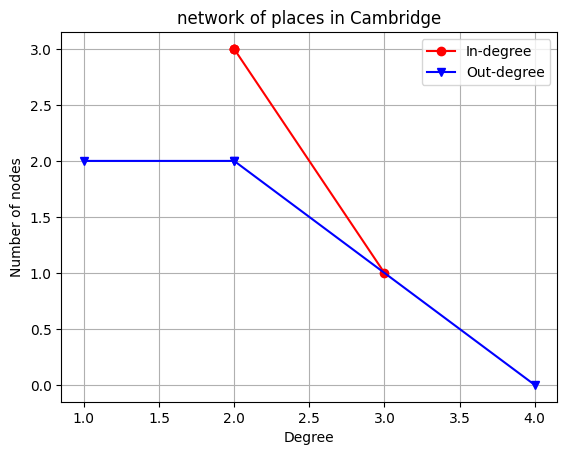

In [121]:
in_degrees = G.in_degree() # dictionary node:degree
in_values = sorted([val for (node, val) in G.in_degree()])
out_values = sorted([val for (node, val) in G.out_degree()])
in_hist = [in_values.count(x) for x in in_values]
out_hist = [out_values.count(x) for x in in_values]

plt.figure()
plt.grid(True)
plt.plot(in_values, in_hist, 'ro-') # in-degree
plt.plot(out_values, out_hist, 'bv-') # out-degree
plt.legend(['In-degree', 'Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('network of places in Cambridge')
# plt.xlim([0, 2*10**2])
# plt.savefig('./output/cam_net_degree_distribution.pdf')
# plt.close()